# Proyek Analisis Sentimen: [Trip Advisor Hotel Reviews]
- **Nama:** Ulfa Stevi Juliana
- **Email:** steviulpa@Gmail.coom
- **ID Dicoding:** MC189D5X2331

#Import library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
tqdm.pandas()

#Data preparation

##Data loading

In [4]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

##Data understanding

In [5]:
df.shape

(20491, 2)

In [7]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

<Axes: xlabel='Rating', ylabel='count'>

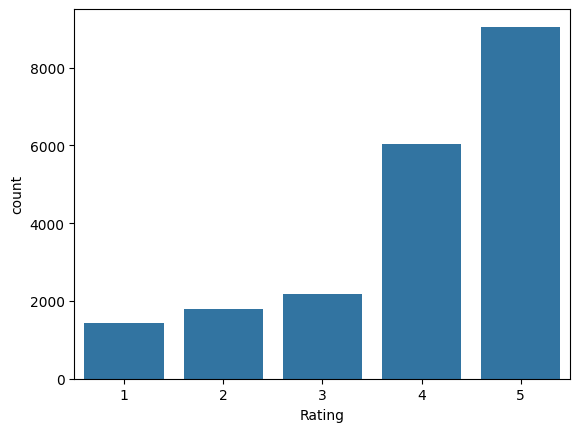

In [8]:
sns.countplot(data=df,x='Rating')

#Encoding label sentimen

In [9]:
def label_encode(x):
    if x == 1 or x == 2 or x == 3 :
        return 0
    if x == 4 or x == 5:
        return 1

def label_name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Positive"

In [10]:
df["sentiment"] = df["Rating"].apply(lambda x: label_encode(x))
df["sentiment_name"] = df["sentiment"].apply(lambda x: label_name(x))

In [11]:
df.head()

Review  Rating  sentiment  \
0  nice hotel expensive parking got good deal sta...       4          1   
1  ok nothing special charge diamond member hilto...       2          0   
2  nice rooms not 4* experience hotel monaco seat...       3          0   
3  unique, great stay, wonderful time hotel monac...       5          1   
4  great stay great stay, went seahawk game aweso...       5          1   

  sentiment_name  
0       Positive  
1       Negative  
2       Negative  
3       Positive  
4       Positive

#Data Preprosessing

In [12]:
!pip install emoji

import re
import emoji
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Inisialisasi stopwords dan stemmer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def clean_text(text):
    # 1. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # 2. Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # 3. Convert emojis to text (e.g., üòÉ -> :smile:)
    text = emoji.demojize(text)

    # 4. Remove digits
    text = re.sub(r'\d+', '', text)

    # 5. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 6. Remove stopwords
    text = ' '.join(word for word in text.split() if word.lower() not in stop_words)

    # 7. Stemming
    text = ' '.join(ps.stem(word) for word in text.split())

    return text

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 590.6/590.6 kB 13.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
df['Review'] = df['Review'].apply(clean_text)
df.head()

Review  Rating  sentiment  \
0  nice hotel expens park got good deal stay hote...       4          1   
1  ok noth special charg diamond member hilton de...       2          0   
2  nice room experi hotel monaco seattl good hote...       3          0   
3  uniqu great stay wonder time hotel monaco loca...       5          1   
4  great stay great stay went seahawk game awesom...       5          1   

  sentiment_name  
0       Positive  
1       Negative  
2       Negative  
3       Positive  
4       Positive

#Data Spliting 70/30

In [14]:
X = df.drop(['sentiment', 'sentiment_name', 'Rating'], axis=1)
y = df['sentiment']

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((14343, 1), (6148, 1), (14343,), (6148,))

#Tokenization with BERT Tokenizer

In [16]:
!pip install transformers
!pip install datasets

In [17]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

In [18]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Ambil kolom teks
train_texts = X_train['Review'].tolist()
test_texts = X_test['Review'].tolist()

# Tokenisasi dan padding
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

# Konversi label ke tensor
train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#Model Training

In [19]:
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

# Buat TensorDataset
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)

# Buat DataLoader
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=16)
val_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=16)

In [20]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from tqdm import tqdm

epochs = 3
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        correct_train_predictions += (predictions == labels).sum().item()
        total_train_samples += labels.size(0)

    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(correct_train_predictions / total_train_samples)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct_val_predictions += (predictions == labels).sum().item()
            total_val_samples += labels.size(0)

    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(correct_val_predictions / total_val_samples)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 897/897 [05:09<00:00,  2.90it/s]


Epoch 1/3, Train Loss: 0.3246, Train Accuracy: 0.8673, Val Loss: 0.2936, Val Accuracy: 0.8735


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 897/897 [05:25<00:00,  2.75it/s]


Epoch 2/3, Train Loss: 0.2204, Train Accuracy: 0.9155, Val Loss: 0.2608, Val Accuracy: 0.8923


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 897/897 [05:25<00:00,  2.75it/s]


Epoch 3/3, Train Loss: 0.1539, Train Accuracy: 0.9409, Val Loss: 0.3062, Val Accuracy: 0.8966


#Model Evaluation

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()

# Akurasi pada test set
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

test_accuracy = correct_predictions / total_predictions
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8966


In [23]:
# Kumpulkan semua prediksi dan label
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.77      0.80      1620
    Positive       0.92      0.94      0.93      4528

    accuracy                           0.90      6148
   macro avg       0.87      0.86      0.86      6148
weighted avg       0.89      0.90      0.90      6148



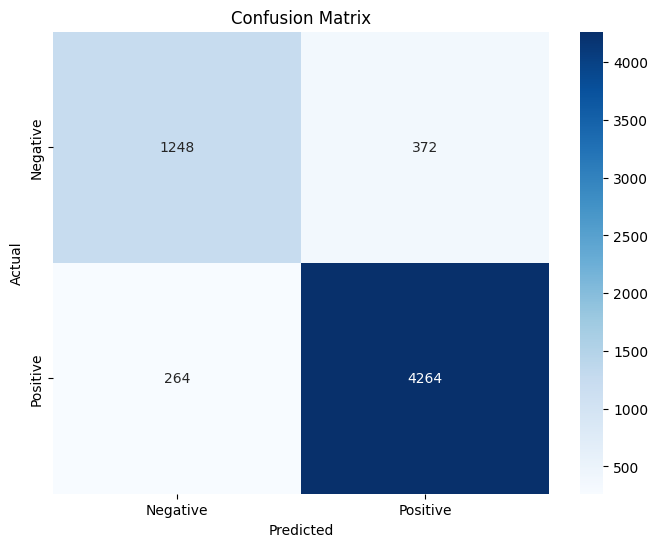

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=["Negative", "Positive"]))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Model Testing

In [27]:
def predict_sentiment(text):
    model.eval()
    inputs = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()

    # Ubah label sesuai dataset kamu
    return ["Negative", "Positive"][prediction]


In [30]:
# Sample English reviews for testing
test_texts = [
    "The service at the hotel was terrible. I'm very disappointed.",
    "The room was clean and comfortable. I had a great stay!",
    "Very satisfied with the quality. Will buy again!",
    "The app works smoothly and is very user-friendly.",
    "It was not what I expected. Definitely not worth the price.",
    "The app keeps crashing and is full of bugs.",
    "I waited two weeks and still haven‚Äôt received my order.",
    "Poor quality and bad packaging.",
    "Waste of money. I won‚Äôt buy from this store again.",
]

# Predict sentiment for each review
for text in test_texts:
    sentiment = predict_sentiment(text)
    print(f"Review: {text}\nPredicted Sentiment: {sentiment}\n")


Review: The service at the hotel was terrible. I'm very disappointed.
Predicted Sentiment: Negative

Review: The room was clean and comfortable. I had a great stay!
Predicted Sentiment: Positive

Review: Very satisfied with the quality. Will buy again!
Predicted Sentiment: Positive

Review: The app works smoothly and is very user-friendly.
Predicted Sentiment: Positive

Review: It was not what I expected. Definitely not worth the price.
Predicted Sentiment: Negative

Review: The app keeps crashing and is full of bugs.
Predicted Sentiment: Negative

Review: I waited two weeks and still haven‚Äôt received my order.
Predicted Sentiment: Negative

Review: Poor quality and bad packaging.
Predicted Sentiment: Negative

Review: Waste of money. I won‚Äôt buy from this store again.
Predicted Sentiment: Negative

